<a href="https://colab.research.google.com/github/hhtnghia321/Backing-Marketing/blob/master/Bank_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

UCI = pd.read_csv("https://raw.githubusercontent.com/hhtnghia321/Backing-Marketing/master/bank-additional-full.csv", sep = ";")
data = pd.DataFrame(UCI)
y = data["y"]
X = data.drop("y", 1)
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


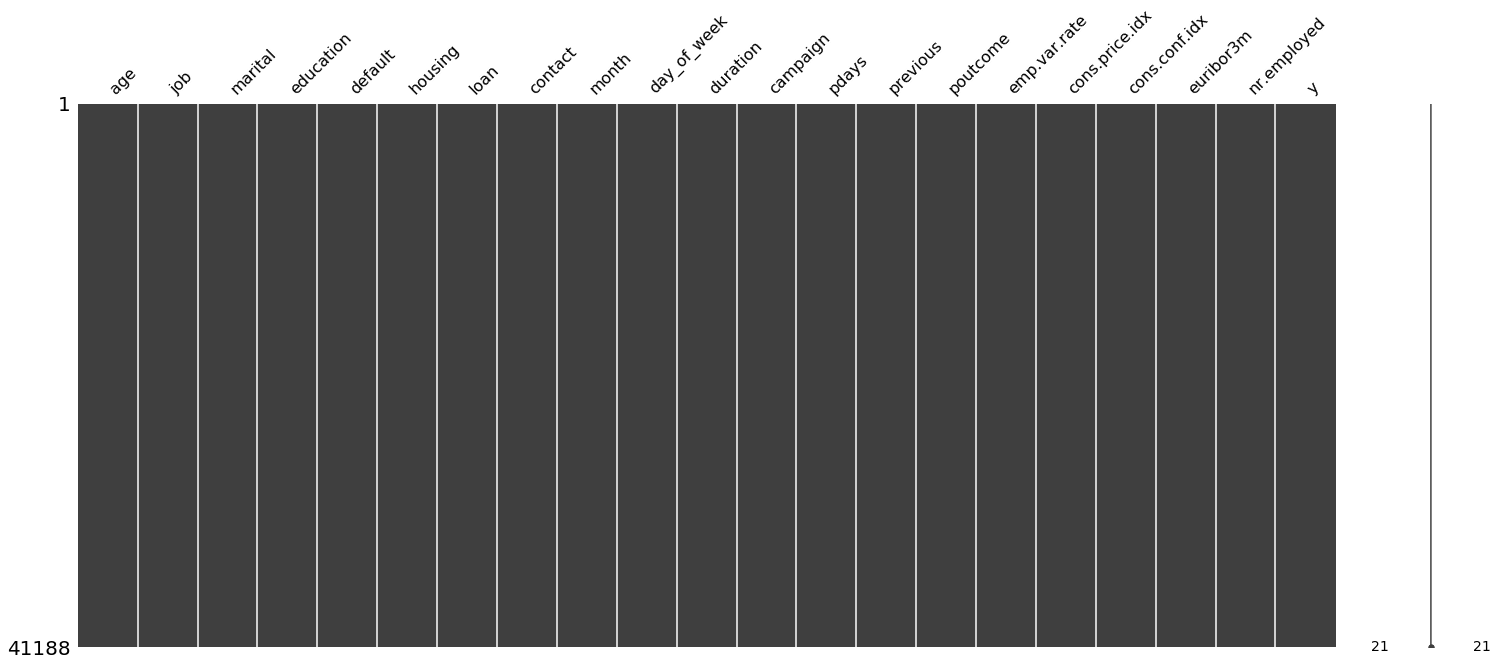

In [ ]:
#check for missing data
import missingno as msno
msno.matrix(data)
#no missing data found

In [ ]:
#check for the biasness in outcome
from collections import Counter
a = Counter(data["y"])
print(a)
#percentage of subcriptions
print("{}%".format(a["yes"]/len(data)*100))

Counter({'no': 36548, 'yes': 4640})
11.265417111780131%


# The Data contained only 11% of "no" class which make its imbalance. However, we planning to use the decision tree model so this may not be a problem

# Since the DecisionTreeClissification of SciKit learn not accept categorical data. We have to OneHotEncode the data into binary variables

In [ ]:
#OnehotEncode
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
y_code = LE.fit_transform(y)
for name in ["job", "marital", "education", "default", "housing", "loan", "contact", "month","day_of_week", "poutcome"]:
  var_dum = pd.get_dummies(X[name])
  X.drop(name, 1 ,inplace= True)
  for name_dum in var_dum.columns:
    var_dum.rename(columns = {name_dum : name + "|" + name_dum}, inplace = True)
  X = pd.concat([X, var_dum],axis=1,sort=False)


In [ ]:
#fit the data with DecisionTree and scoring by each K
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state= 121)
score = {"5" : [], "6" : []
        , "7" : [], "8" : []
        , "9" : [], "10" : []}
        
import sklearn.model_selection as model_sel
#loop throught each K of K-fold Crossvalidation 
for j in [5,6,7,8,9,10]:
  score[str(j)].append(model_sel.cross_val_score(tree, X,y_code , cv = j))

#best fold
print(score["10"])
#worst fold
print(score["5"])
#average score of each fold
Average_score = {i: np.mean(v) for i, v in score.items()}
print(Average_score)

[array([0.88905074, 0.8519058 , 0.76984705, 0.85093469, 0.8358825 ,
       0.78732702, 0.3636805 , 0.31585336, 0.65954347, 0.17921321])]
[array([0.8884438 , 0.36246662, 0.61204176, 0.17870584, 0.14131359])]
{'5': 0.4365943194810524, '6': 0.45841821698977564, '7': 0.540691463533068, '8': 0.5873315665204867, '9': 0.6091117335860071, '10': 0.6503238348307356}


Let looking at one of the best data set of 10 fold and 5 fold cross-validation

In [ ]:
#split the data for trainning and validation (K-fold cross validation)
#loop for K = 5,6,7,8,9,10
data_Dict = {"5" : {"train_{}" : 1, "test_{}" : 1}, "6" : {"train_{}" : 1, "test_{}" : 1}
             , "7" : {"train_{}" : 1, "test_{}" : 1}, "8" : {"train_{}" : 1, "test_{}" : 1}
             , "9" : {"train_{}" : 1, "test_{}" : 1}, "10" : {"train_{}" : 1, "test_{}" : 1}}

for j in [5,6,7,8,9,10]:
  Fold = model_sel.StratifiedKFold(n_splits= j)
  i = 0
  for train_index, test_index in Fold.split(X,y):
    data_Dict[str(j)].update({"train_{}".format(i):pd.concat([X.iloc[train_index], y.iloc[train_index]],axis= 1)})
    data_Dict[str(j)].update({"test_{}".format(i):pd.concat([X.iloc[test_index], y.iloc[test_index]],axis= 1)})
    i += 1
data_Dict["5"]["train_1"].head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job|admin.,job|blue-collar,job|entrepreneur,job|housemaid,job|management,job|retired,job|self-employed,job|services,job|student,job|technician,job|unemployed,job|unknown,marital|divorced,marital|married,marital|single,marital|unknown,education|basic.4y,education|basic.6y,education|basic.9y,education|high.school,education|illiterate,education|professional.course,education|university.degree,education|unknown,default|no,default|unknown,default|yes,housing|no,housing|unknown,housing|yes,loan|no,loan|unknown,loan|yes,contact|cellular,contact|telephone,month|apr,month|aug,month|dec,month|jul,month|jun,month|mar,month|may,month|nov,month|oct,month|sep,day_of_week|fri,day_of_week|mon,day_of_week|thu,day_of_week|tue,day_of_week|wed,poutcome|failure,poutcome|nonexistent,poutcome|success,y
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,no
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,no
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,no
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,no
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,no


In [ ]:
#get the best model from cross-validation dataset
tree1 = DecisionTreeClassifier(random_state= 121)
tree_mol_10_0 = tree.fit(data_Dict["10"]["train_0"].drop("y",1),data_Dict["10"]["train_0"]["y"])
print("Best Tree Score: " , tree_mol_10_0.score(data_Dict["10"]["test_0"].drop("y",1), data_Dict["10"]["test_0"]["y"]))
print("Best Tree Depth: " , tree_mol_10_0.get_depth())
print("Best Tree No.Leave: " , tree_mol_10_0.get_n_leaves())

#get the worst model from cross-validation dataset
tree2 = DecisionTreeClassifier(random_state= 121)
tree_mol_5_4 = tree2.fit(data_Dict["5"]["train_4"].drop("y",1),data_Dict["5"]["train_4"]["y"])
print("Worst Tree Score: " , tree_mol_5_4.score(data_Dict["5"]["test_4"].drop("y",1),data_Dict["5"]["test_4"]["y"]))
print("Worst Tree Depth: " , tree_mol_5_4.get_depth())
print("Worst Tree No.Leave: " , tree_mol_5_4.get_n_leaves())

Best Tree Score:  0.8890507404709881
Best Tree Depth:  27
Best Tree No.Leave:  2596
Worst Tree Score:  0.1413135850430982
Worst Tree Depth:  30
Worst Tree No.Leave:  1597


Now, Let use the final test data set to test the best and the worst models

In [ ]:
#import real test data to test the best model
UCI_test = pd.read_csv("https://raw.githubusercontent.com/hhtnghia321/Backing-Marketing/master/bank-additional.csv", sep = ";")
data_test = pd.DataFrame(UCI_test)

y_2 = data_test["y"]
X_2 = data_test.drop("y", 1)

#OnehotEncode data_test
y_code = LE.fit_transform(y_2)
for name in ["job", "marital", "education", "default", "housing", "loan", "contact", "month","day_of_week", "poutcome"]:
  var_dum = pd.get_dummies(X_2[name])
  X_2.drop(name, 1 ,inplace= True)
  for name_dum in var_dum.columns:
    var_dum.rename(columns = {name_dum : name + "|" + name_dum}, inplace = True)
  X_2 = pd.concat([X_2, var_dum],axis=1,sort=False)

print("The Best model real score: ", tree_mol_10_0.score(X_2,y_2))
print("The Worst model real score: ", tree_mol_5_4.score(X_2,y_2))

The Best model real score:  0.98761835396941
The Worst model real score:  0.824957513959699


Download the Decision tree map of the best and the worst tree

In [ ]:
!apt-get install python-pydot
!pip install pydotplus
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus
from google.colab import files

#download Best model map
dot_data = StringIO()
export_graphviz(tree_mol_10_0, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("plot.pdf")
files.download('plot.pdf') 

#download Worst model map
dot_data2 = StringIO()
export_graphviz(tree_mol_5_4, out_file=dot_data2)
graph2 = pydotplus.graph_from_dot_data(dot_data2.getvalue())  
graph2.write_pdf("plot2.pdf")
files.download('plot2.pdf')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pydot is already the newest version (1.2.3-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
